# COGS 108 - Final Project 

# Overview

My project analyzes the relationship between the yelp ratings of San Diego parks and the CalEnviroScreen 2.0 score of the region the parks are in. After combining the data, my analysis showed a negative correlation between a park's yelp rating and its CES 2.0 score. This means that parks that are in an environmentally healthy region (have a low CES 2.0 score) generally have a higher review rating.

# Name & GitHub

- Name: Nicholas Willison
- GitHub Username: nwilliso

# Research Question

What is the relationship between yelp review ratings of San Diego parks and the CalEnviroScreen (CES) 2.0 score of the region they are in?

## Background and Prior Work

The city of San Diego has over 400 parks, which combined takes up more than 40,000 acres of space. There are also 90 joint use agreements with local school districts for around 370 acres of additional recreational land during non-school hours ([1]). A survey conducted by the city of San Diego found that 85% and 83% of the people surveyed were satisfied with the availability of parks and the hours of access at parks respectively ([2]). A data analysis study by The Trust for Public Land ranked San Diego as the 18th best city in the United States based off of their ranking systems for parks, which takes into account factors such as walking distance and amount of amenities ([3]). The University of San Diego also takes this data from The Trust for Public Land and complies the data into easy-to-view tables comparing San Diego to other surrounding cities and comparable cities around the United States ([4]). However, these are ratings for parks at a city level and not an individual one, and that is not enough specificity for San Diego, a city that has over 400 parks. Yelp allows people to review or search up reviews of specific parks and then ranks the park on a scale from 1 star to 5 stars ([5]).

According to Numbeo, San Diego is a relatively environmentally healthy city. It has low to moderate pollution and moderate to high cleanliness ([6]). However, San Diego encompasses a lot of area. The tool CalEnviroScreen 2.0 allows one to zoom into certain census tracts within San Diego and see more details about the environmental health such as the pollution burden for example ([7]). Research from the National Recreation and Park Association shows that trees in parks can help the environment. Parks especially help when it comes to reducing pollution and bettering air quality. The report also gives a list of goals for park management ([8]). Despite the data that exists for park ratings and environmental health, no one has tried to find the relationship between environmental health and the quality or rating of parks.

References (include links):
- [1] https://www.sandiego.gov/park-and-recreation/general-info
- [2] https://www.sandiego.gov/sites/default/files/sandiego_2018_survey_findings_report_-_final_0.pdf
- [3] https://www.tpl.org/city/san-diego-california
- [4] https://www.sandiego.edu/soles/hub-nonprofit/initiatives/dashboard/park-access.php
- [5] https://www.yelp.com/search?find_desc=Parks&find_loc=San+Diego%2C+CA
- [6] https://www.numbeo.com/pollution/in/San-Diego
- [7] https://data.ca.gov/dataset/calenviroscreen-2-0
- [8] https://www.nrpa.org/globalassets/research/nowak-heisler-summary.pdf

# Hypothesis


I believe that there will be a higher yelp rating of a park in a region that has a lower CES score (so a negative correlation). My reasoning is that a lower CES score means a better environment and environmental beauty which would, in turn, lead to higher ratings! For example, a park with a lot of pollution would have a higher CES score and probably lower ratings as a result.

# Dataset(s)

- Dataset Name: California Environmental Health Screening Data
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8035

This dataset uses a score to rate California census tracts' based on multiple sources of pollution included in the dataset as well. The lower the score, the better the environmental health.

I plan to combine this with the San Diego Census Tracts dataset to have shapely polygons for each CES Score. Also, I plan to assign each park in the Yelp data its respective CES score based on what census tract the park is in.

- Dataset Name: San Diego Parks Yelp Data
- Link to the dataset: https://www.yelp.com/ (Prof Ellis curated these data)
- Number of observations: 833

This dataset has the average amount of stars (from 1 through 5 in steps of .5) each San Diego park was rated on Yelp as well as the number of reviews and location of the parks.

I plan to combine each park's rating with its respective CES data based on its location. I will do this by seeing if the parks' latitude and longitude are within the census tract's shapely polygons.

- Dataset Name: San Diego Census Tracts
- Link to the dataset: https://sdgis-sandag.opendata.arcgis.com/datasets/census-tracts (specifically https://gissd.sandag.org/rdw/rest/services/Census/Census_ZIP/MapServer/1/query?where=1%3D1&outFields=Shape,CT&outSR=4326&f=json)
- Number of observations: 627

This dataset has shapely polygon objects for each census tract in San Diego.

I plan to combine this data with the CES data by merging the two datasets based on the census tract id.

In summary, I will merge the census tract data with the CES data based on census tract ids, and then I will combine the CES data and yelp data based on if the park's location from the yelp data is within the census tract's polygon.

# Setup

In [1]:
# imports 

#!pip install geopy
#!pip install geopandas
#!pip install descartes
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from shapely.ops import cascaded_union

import patsy
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import ttest_ind, chisquare, normaltest

import seaborn as sns
sns.set()
sns.set_context('talk')


In [2]:
# read data
df_health = pd.read_csv("/Users/nick/COGS108/Project/individual_fa20/data/calenviroscreen-final-report.csv")
df_yelp = pd.read_csv("/Users/nick/COGS108/Project/individual_fa20/data/yelp_SD_parks.csv")
df_census = gpd.read_file("https://gissd.sandag.org/rdw/rest/services/Census/Census_ZIP/MapServer/1/query?where=1%3D1&outFields=Shape,CT&outSR=4326&f=json")


# Data Cleaning

Checking what columns the CES data has

In [3]:
# getting a peak at the CES data
print(df_health.columns)
df_health.head()


Index(['Census Tract', 'Total Population', 'California County',
       'Click for interactive map', 'CES 2.0 Score',
       'CES 2.0 Percentile Range', 'Hyperlink', 'Ozone', 'Ozone Pctl', 'PM2.5',
       'PM2.5 Pctl', 'Diesel PM', 'Diesel PM Pctl', 'Drinking Water',
       'Drinking Water Pctl', 'Pesticides', 'Pesticides Pctl', 'Tox. Release',
       'Tox. Release Pctl', 'Traffic', 'Traffic Pctl', 'Cleanup Sites',
       'Cleanup Sites Pctl', 'Groundwater Threats', 'Groundwater Threats Pctl',
       'Haz. Waste', 'Haz. Waste Pctl', 'Imp. Water Bodies',
       'Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl',
       'Pollution Burden', 'Pollution Burden Score', 'Pollution Burden Pctl',
       'Age', 'Age Pctl', 'Asthma', 'Asthma Pctl', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Education', 'Education Pctl',
       'Linguistic Isolation', 'Linguistic Isolation Pctl', 'Poverty',
       'Poverty Pctl', 'Unemployment', 'Unemployment Pctl', 'Pop. Char. ',
       'Pop. Ch

,Census Tract,Total Population,California County,Click for interactive map,CES 2.0 Score,CES 2.0 Percentile Range,Hyperlink,Ozone,Ozone Pctl,PM2.5,...,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,Location 1
0,6019001100,3174,Fresno,NaN,89.22,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.255228,80.87,14.746087,...,21.6,83.66,77.500865,97.78,19.30,92.05,90.072268,9.360658,99.60,"Fresno 93706\n(36.709695199999999, -119.7816961)"
1,6019000300,3609,Fresno,NaN,83.71,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.287130,83.28,14.619618,...,18.3,78.34,81.204032,98.93,NaN,NaN,92.323243,9.594592,99.90,"Fresno 93706\n(36.726461999999998, -119.8010347)"
2,6019000200,3167,Fresno,NaN,83.47,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.304446,84.40,14.554656,...,16.2,74.04,86.828423,99.66,25.27,98.14,91.499039,9.508958,99.80,"Fresno 93706\n(36.735491400000001, -119.8055044)"
3,6019001500,2206,Fresno,NaN,83.08,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.225687,78.25,14.937649,...,19.5,80.68,62.746088,88.32,18.30,89.60,83.474281,8.674967,97.74,"Fresno 93725\n(36.681600000000003, -119.717842..."
4,6019000600,6161,Fresno,NaN,82.95,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.327935,85.81,14.506413,...,16.9,75.49,88.680993,99.79,26.69,98.61,92.246260,9.586590,99.89,"Fresno 93721\n(36.743062999999999, -119.7933565)"


Dropping all percentile columns as well as useless columns for this data analysis such as the population, interactive map, and hyperlink. Also, I drop any observation that is not in San Diego County because this data analysis only pertains to parks in San Diego. **Note:** this means that our analysis will only pertain to San Diego and should not be extrapolated to other regions.

In [4]:
# all environmental columns used to calculate the CES score
enviro = ['Ozone','PM2.5','Diesel PM','Drinking Water','Pesticides','Tox. Release','Traffic','Cleanup Sites','Groundwater Threats','Haz. Waste','Imp. Water Bodies','Solid Waste','Pollution Burden', 'Pollution Burden Score','Age','Asthma','Low Birth Weight','Education','Linguistic Isolation','Poverty','Unemployment', 'Total Population']

# dropping columns and non San Diego observations
df_min_health = df_health.loc[df_health["California County"] == "San Diego"][["Census Tract", "CES 2.0 Score","Location 1",'Ozone','PM2.5','Diesel PM','Drinking Water','Pesticides','Tox. Release','Traffic','Cleanup Sites','Groundwater Threats','Haz. Waste','Imp. Water Bodies','Solid Waste','Pollution Burden', 'Pollution Burden Score','Age','Asthma','Low Birth Weight','Education','Linguistic Isolation','Poverty','Unemployment', 'Total Population']]
df_min_health.head()


,Census Tract,CES 2.0 Score,Location 1,Ozone,PM2.5,Diesel PM,Drinking Water,Pesticides,Tox. Release,Traffic,...,Pollution Burden,Pollution Burden Score,Age,Asthma,Low Birth Weight,Education,Linguistic Isolation,Poverty,Unemployment,Total Population
165,6073005000,59.91,"San Diego 92113\n(32.694850199999998, -117.141...",0.000812,10.404164,32.45,233.407874,0.0,4410.638376,2073.474921,...,59.419884,7.203297,23.8,81.370000,0.052379,46.8,32.9,74.855946,NaN,2227
299,6073003601,55.61,"San Diego 92113\n(32.690986199999998, -117.116...",0.001435,10.460384,27.50,233.407874,0.0,644.541122,3514.190077,...,54.822326,6.645896,24.9,81.370000,0.050398,65.3,27.3,76.636392,17.84,3250
370,6073004900,54.23,"San Diego 92113\n(32.701852600000002, -117.138...",0.000923,10.430966,38.20,233.407874,0.0,450.780581,2954.337948,...,55.583873,6.738271,24.9,81.370000,0.050310,49.1,37.3,70.019802,13.77,5028
466,6073003902,52.48,"San Diego 92113\n(32.696748999999997, -117.126...",0.001166,10.449528,32.75,233.407874,0.0,539.959423,2863.847330,...,51.062659,6.190205,24.2,81.370000,0.050918,61.3,37.2,76.470588,19.39,4927
805,6073003901,47.82,"San Diego 92113\n(32.703556800000001, -117.126...",0.001217,10.469327,32.80,233.407874,0.0,326.642042,1540.867302,...,46.297498,5.612438,24.3,80.064873,0.050820,63.5,28.4,79.242069,28.52,4241


In [5]:
# taking only relevant part of census tract id since the first few digits indicate San Diego
df_min_health["Census Tract"] = df_health.loc[df_health["California County"] == "San Diego"]["Census Tract"].astype(str).str[5:]
df_min_health = df_min_health.sort_values(by=['Census Tract'])

# converting all census tracts to ints
df_min_health["CT"] = df_min_health["Census Tract"].astype(int)

#extracting zip from location
new = df_min_health["Location 1"].str.split("\n", n = 1, expand = True)
df_min_health["zip"] = new[0].str[-5:]
df_min_health.head()


,Census Tract,CES 2.0 Score,Location 1,Ozone,PM2.5,Diesel PM,Drinking Water,Pesticides,Tox. Release,Traffic,...,Age,Asthma,Low Birth Weight,Education,Linguistic Isolation,Poverty,Unemployment,Total Population,CT,zip
4991,00100,18.94,"San Diego 92103\n(32.753005299999998, -117.185...",0.001691,10.386254,25.29,233.407874,0.0,51.421604,2240.129107,...,31.6,41.778867,0.049734,1.1,2.0,11.012007,8.34,3029,100,92103
6143,00201,14.12,"San Diego 92103\n(32.754002800000002, -117.173...",0.001816,10.433468,25.46,233.407874,0.0,56.074192,1094.116177,...,30.0,46.110000,0.047645,4.8,1.2,21.083070,7.28,1801,201,92103
7343,00202,8.77,"San Diego 92103\n(32.745384600000001, -117.175...",0.001600,10.412274,25.76,233.407874,0.0,61.952811,1366.586187,...,20.8,43.500299,0.046713,3.3,1.3,17.216030,4.64,4208,202,92103
6209,00300,13.90,"San Diego 92103\n(32.744780300000002, -117.162...",0.001685,10.455865,31.44,233.407874,0.0,66.448120,1327.263707,...,20.5,46.110000,0.050811,6.3,3.6,24.639610,5.09,4732,300,92103
6430,00400,13.04,"San Diego 92103\n(32.753332299999997, -117.163...",0.001889,10.468304,31.31,233.407874,0.0,59.896925,1842.022632,...,13.1,43.253663,0.049166,3.0,2.7,30.621302,6.62,3669,400,92103


Here, I am merging the census tract data with the CES data in order to have shapely polygons as a part of each CES observation.

In [6]:
# merging CES data and census by tract id (as well as dropping extra rows from CES data)
df_CT_health = pd.merge(right = df_census, left = df_min_health[["CT","CES 2.0 Score","zip",'Ozone','PM2.5','Diesel PM','Drinking Water','Pesticides','Tox. Release','Traffic','Cleanup Sites','Groundwater Threats','Haz. Waste','Imp. Water Bodies','Solid Waste','Pollution Burden', 'Pollution Burden Score','Age','Asthma','Low Birth Weight','Education','Linguistic Isolation','Poverty','Unemployment', 'Total Population']], right_on = "CT", left_on = "CT")

# sorting by zip code
df_CT_health = df_CT_health.sort_values(by="zip").reset_index(drop=True).rename(columns={"CT": "tract", "CES 2.0 Score": "score"})
df_CT_health.head()


,tract,score,zip,Ozone,PM2.5,Diesel PM,Drinking Water,Pesticides,Tox. Release,Traffic,...,Pollution Burden Score,Age,Asthma,Low Birth Weight,Education,Linguistic Isolation,Poverty,Unemployment,Total Population,geometry
0,21206,13.67,91901,0.103451,10.425038,1.79,731.482928,0.000000,16.101099,1340.920794,...,4.767729,25.7,21.029756,0.051303,5.7,0.0,22.241559,4.93,2995,"POLYGON ((-116.71956 32.88903, -116.71954 32.8..."
1,21205,10.31,91901,0.092098,10.544714,1.96,226.355388,0.000000,20.793283,982.962672,...,3.373257,25.8,21.025000,0.040177,10.5,1.2,30.024737,8.98,6801,"POLYGON ((-116.80558 32.84788, -116.80457 32.8..."
2,21204,7.81,91901,0.067550,10.500927,1.07,730.985889,0.000000,20.372290,534.510243,...,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239,"POLYGON ((-116.68590 32.84218, -116.68495 32.8..."
3,21202,16.62,91901,0.044489,9.932539,0.47,561.986322,0.051963,10.183791,386.674361,...,4.152988,22.1,22.615560,0.050713,11.5,3.3,37.248996,11.58,3156,"POLYGON ((-116.61197 32.91436, -116.61180 32.9..."
4,13412,13.13,91902,0.002573,10.469107,12.81,187.725066,0.000000,137.336300,2816.213976,...,3.681052,25.2,37.993585,0.045172,6.0,10.3,7.864727,10.35,5086,"POLYGON ((-117.03121 32.66112, -117.03093 32.6..."


In [7]:
# extract ZIP code from address
df_yelp["zip"] = df_yelp.address.str[-5:]
df_min_yelp = df_yelp.sort_values(by="zip").reset_index(drop=True)

# checking for non zip codes
df_min_yelp.zip.unique()


array(['90069', '90670', '90717', '90815', '91010', '91302', '91763',
       '91765', '91902', '91910', '91911', '91913', '91914', '91915',
       '91916', '91932', '91941', '91942', '91945', '91950', '91977',
       '92004', '92007', '92008', '92009', '92011', '92014', '92019',
       '92020', '92021', '92023', '92024', '92025', '92026', '92027',
       '92028', '92029', '92033', '92036', '92037', '92038', '92039',
       '92040', '92054', '92057', '92058', '92064', '92065', '92071',
       '92074', '92075', '92078', '92083', '92084', '92093', '92101',
       '92102', '92103', '92104', '92105', '92106', '92107', '92108',
       '92109', '92110', '92111', '92113', '92114', '92115', '92116',
       '92117', '92118', '92119', '92120', '92121', '92122', '92123',
       '92124', '92126', '92127', '92128', '92129', '92130', '92131',
       '92132', '92135', '92136', '92139', '92145', '92154', '92166',
       '92171', '92172', '92173', '92182', '92321', '92624', '92626',
       '92627', '926

As we see above, there are two cases that did not give a zip code, so we will check those out.

In [8]:
# checking out edge cases
df_min_yelp[(df_min_yelp['zip'] == 'o, CA') | (df_min_yelp['zip'] == 'exico')]


,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed,zip
828,Parque Teniente Guerrero,Carrillo Puerto y o Tercera Col. Zona Centro 2...,5.266470e+11,NWyA4E97gBIul_iOopUK4g,https://www.yelp.com/biz/parque-teniente-guerr...,4.5,20,-117.045828,32.532675,False,exico
829,Arco del Milenio,"Av. Revolución S/N Col. Centro 22000 Tijuana, ...",5.266470e+11,9BM1QXzySQThR-Dhnt1d_w,https://www.yelp.com/biz/arco-del-milenio-tiju...,3.0,13,-117.037115,32.536475,False,exico
830,City of Otay Mesa,"San Diego, CA",NaN,bc_LR0UUGK4vYPdOVgaJTQ,https://www.yelp.com/biz/city-of-otay-mesa-san...,5.0,1,-116.958728,32.567567,False,"o, CA"
831,Officer Christopher Wilson Memorial Park,"San Diego, CA",NaN,fg97iBKVfgNgf3ehS6Rkvw,https://www.yelp.com/biz/officer-christopher-w...,4.0,1,NaN,NaN,False,"o, CA"
832,Miner's Ridge Loop Trail,"Carmel Valley Rd San Diego, CA",NaN,g6azO44GuLhv0hazX2wFHg,https://www.yelp.com/biz/miners-ridge-loop-tra...,4.0,4,-117.119760,32.993670,False,"o, CA"


We will drop the parks in Mexico since we are only doing data analysis pertaining to San Diego. For the 3 other observations, I will use Google Maps to find the missing information (zip code for all three and longitude and latitude for the memorial park).

In [9]:
# drop parks not in San Diego
df_min_yelp = df_min_yelp.loc[df_min_yelp['zip'] != 'exico']
df_min_yelp = df_min_yelp.reset_index(drop=True)
df_min_yelp.tail()


,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed,zip
826,Rolling Hills Park,"1515 E Bastanchury Rd Fullerton, CA 92835",NaN,ya1wq__cqzyr6zaKz4SnzA,https://www.yelp.com/biz/rolling-hills-park-fu...,5.0,6,-117.899939,33.900170,False,92835
827,Kellogg Park,"1635 Kellogg Ave Corona, CA 92879",NaN,SOze2uj3o49RpRtcbTsQFA,https://www.yelp.com/biz/kellogg-park-corona?a...,3.5,7,-117.558147,33.863342,False,92879
828,City of Otay Mesa,"San Diego, CA",NaN,bc_LR0UUGK4vYPdOVgaJTQ,https://www.yelp.com/biz/city-of-otay-mesa-san...,5.0,1,-116.958728,32.567567,False,"o, CA"
829,Officer Christopher Wilson Memorial Park,"San Diego, CA",NaN,fg97iBKVfgNgf3ehS6Rkvw,https://www.yelp.com/biz/officer-christopher-w...,4.0,1,NaN,NaN,False,"o, CA"
830,Miner's Ridge Loop Trail,"Carmel Valley Rd San Diego, CA",NaN,g6azO44GuLhv0hazX2wFHg,https://www.yelp.com/biz/miners-ridge-loop-tra...,4.0,4,-117.119760,32.993670,False,"o, CA"


In [10]:
# zip for City of Otay Mesa
df_min_yelp.iloc[(828,10)] = "92154"

# coordinates and zip for Officer Christopher Wilson Memorial Park
df_min_yelp.iloc[(829, 7)] = -117.04147656787906
df_min_yelp.iloc[(829,8)] = 32.70553718742855
df_min_yelp.iloc[(829,10)] = "92144"

# zip for Miner's Ridge Loop Trail
df_min_yelp.iloc[(830,10)] = "92129"
df_min_yelp[df_min_yelp['zip'] == 'o, CA']

# resorting with new zip codes
df_min_yelp = df_min_yelp.sort_values(by="zip").reset_index(drop=True)


Now using the longitude and latitude of these observations, I will create shapely points so analysis is easier.

In [11]:
# create shapely points
df_min_yelp["geometry"]=gpd.points_from_xy(x=df_min_yelp.longitude, y=df_min_yelp.latitude)

# drop colums that ar no longer needed
df_min_yelp = df_min_yelp.drop(columns=["address","phone","id","url","is_closed", "longitude", "latitude"])
df_min_yelp.head()


,name,rating,review_count,zip,geometry
0,Enjoy The Mountain,4.5,53,90069,POINT (-118.37935 34.08805)
1,Lakeview Park,4.0,4,90670,POINT (-118.08704 33.94205)
2,Lomita Park,3.5,17,90717,POINT (-118.31441 33.80345)
3,Los Altos Park,3.5,9,90815,POINT (-118.12770 33.79659)
4,Encanto Park,4.5,19,91010,POINT (-117.93806 34.14291)


Time to merge the yelp reviews with the CES data based on if the yelp coordinates are in the CES polygon! **Note:** it is possible that some of these parks span across multiple different census tracts and therefore do not fit neatly into one CES score, so it is important to note as a possible error during analysis.

In [12]:
# a function to combine the yelp ratings with the CES data
def get_score(yelp,scores):
    # create new score column with null values
    yelp['score'] = np.nan
    # also create new columns for enviro columns
    yelp[enviro] = pd.DataFrame([[np.nan]*len(enviro)], index=yelp.index)
    
    # for each yelp observation
    for i in range(len(yelp)):
        # zoom into the part of the CES dataframe that has the same zip code as the yelp observation
        loc = scores.loc[scores["zip"] == yelp.iloc[i][3]]
        loc = loc.reset_index(drop=True)
        # to indicate if found
        status = True
        # for each CES observation with the same zip code
        for j in range(len(loc)):
            # if the park's coordinates are inside the CES's polygon
            if yelp.iloc[i][4].within(loc.iloc[j][25]):
                # add CES score to yelp observation
                yelp.iloc[(i,5)] = loc.iloc[j][1]
                # add CES enviro data to yelp observation as well
                for c in range(len(enviro)):
                    yelp.iloc[(i,6+c)] = loc.iloc[j][3+c]
                # found CES data so break 
                status = False
                break
        # if not found
        if status:
            # check through all CES data (not just ones with same zip code)
            for k in range(len(scores)):
                # same as above
                if yelp.iloc[i][4].within(scores.iloc[k][25]):
                    yelp.iloc[(i,5)] = scores.iloc[k][1]
                    for c in range(len(enviro)):
                        yelp.iloc[(i,6+c)] = scores.iloc[j][3+c]
                    break
                

# run function on the dataframes and look at the result
get_score(df_min_yelp, df_CT_health)
df_min_yelp


,name,rating,review_count,zip,geometry,score,Ozone,PM2.5,Diesel PM,Drinking Water,...,Pollution Burden,Pollution Burden Score,Age,Asthma,Low Birth Weight,Education,Linguistic Isolation,Poverty,Unemployment,Total Population
0,Enjoy The Mountain,4.5,53,90069,POINT (-118.37935 34.08805),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lakeview Park,4.0,4,90670,POINT (-118.08704 33.94205),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lomita Park,3.5,17,90717,POINT (-118.31441 33.80345),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Los Altos Park,3.5,9,90815,POINT (-118.12770 33.79659),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Encanto Park,4.5,19,91010,POINT (-117.93806 34.14291),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,Newport Landing Whale Watching and Sportfishing,3.5,920,92661,POINT (-117.90062 33.60346),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,Quality Mobile Screens,5.0,246,92707,POINT (-117.87033 33.70137),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
828,Memorial Park,3.5,11,92707,POINT (-117.87839 33.71906),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
829,Rolling Hills Park,5.0,6,92835,POINT (-117.89994 33.90017),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Yikes, there's a lot of null values. Let's check out Kellogg Park, since I know there is one in La Jolla.

In [13]:
# check parks named Kellogg Park
df_yelp.loc[df_yelp["name"] == "Kellogg Park"]


,name,address,phone,id,url,rating,review_count,longitude,latitude,is_closed,zip
326,Kellogg Park,"8200 Camino Del Oro La Jolla, CA 92037",NaN,KysNW3APY9wYpw4HXebeDg,https://www.yelp.com/biz/kellogg-park-la-jolla...,5.0,17,-117.257187,32.856230,False,92037
327,Kellogg Park,"1635 Kellogg Ave Corona, CA 92879",NaN,SOze2uj3o49RpRtcbTsQFA,https://www.yelp.com/biz/kellogg-park-corona?a...,3.5,7,-117.558147,33.863342,False,92879


Luckily, Corona is pretty far away from San Diego! Let's take a look at parks that exist in CES boundaries but didn't get a score.

In [14]:
# make a polygon of all original census tract polygons combined
boundary = gpd.GeoSeries(cascaded_union(df_census.geometry))

# empty array to store edge cases
array = []

# for each observation where the score is null
for i in range(len(df_min_yelp[df_min_yelp.score.isna()])):
    # if the coordinates exist within the combined polygon, add it to the array
    if df_min_yelp[df_min_yelp.score.isna()].iloc[i][4].within(boundary[0]):
        array.append(df_min_yelp[df_min_yelp.score.isna()].iloc[i][0])
        
# how many got missed
print(str(len(array)) + " out of " + str(len(df_min_yelp[df_min_yelp.score.isna()])) + " exist in the boundary")

# take a look at the array
array

10 out of 33 exist in the boundary


['Capt. John Grim "The Salty Doc"',
 'Burial At Sea San Diego',
 'Harbor Island Park',
 'Summer Pops',
 'Burials At Sea',
 'Spanish Landing Park East',
 'Sun Country Coastal - San Diego',
 'Coronado Bridge',
 'Coasterra',
 'San Diego Burial At Sea']

Luckily, the majority of the null values were because the parks were not a part of San Diego. Also, the ones that were in San Diego were parks in the sea, which is why there is no CES score for them! Thus, we will drop any observations without a CES score.

In [15]:
# drop null score observations
df=df_min_yelp[df_min_yelp.score.notna()][["rating","review_count","score"]+enviro].reset_index(drop=True)
df

,rating,review_count,score,Ozone,PM2.5,Diesel PM,Drinking Water,Pesticides,Tox. Release,Traffic,...,Pollution Burden,Pollution Burden Score,Age,Asthma,Low Birth Weight,Education,Linguistic Isolation,Poverty,Unemployment,Total Population
0,3.0,62,8.97,0.002326,10.631078,3.92,187.725066,0.0,86.448769,755.554002,...,22.089365,2.677779,25.5,26.283473,0.049890,5.2,6.4,13.774360,7.90,7073.0
1,5.0,12,15.50,0.002377,10.559833,8.24,187.090866,0.0,107.046038,1639.020049,...,29.020287,3.518002,26.7,25.923572,0.052451,11.3,4.8,24.924925,7.13,5890.0
2,4.5,144,15.50,0.002377,10.559833,8.24,187.090866,0.0,107.046038,1639.020049,...,29.020287,3.518002,26.7,25.923572,0.052451,11.3,4.8,24.924925,7.13,5890.0
3,4.0,34,8.97,0.002326,10.631078,3.92,187.725066,0.0,86.448769,755.554002,...,22.089365,2.677779,25.5,26.283473,0.049890,5.2,6.4,13.774360,7.90,7073.0
4,4.5,259,44.04,0.001651,10.308644,6.26,187.725066,0.0,709.580339,3147.468890,...,46.602725,5.649533,22.4,44.074072,0.054830,35.2,25.2,68.760908,20.86,4466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,3.5,162,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,534.510243,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0
794,5.0,2,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,534.510243,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0
795,4.0,159,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,534.510243,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0
796,4.0,119,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,534.510243,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0


# Data Analysis & Results

Some ratings may be highly biased due to having such a low amount of reviews, so I will add a column for Laplace smoothing of these ratings. Laplace smoothing for 5 star ratings consists of adding each star amount to the original rating, and then dividing by the original review count plus the 5 extra ratings we added.

In [16]:
# laplace smoothing
df['smooth']= ((df['rating']*df['review_count'])+15)/(df['review_count']+5)

# reorder columns
df=df[['review_count','rating','smooth','score']+enviro].rename(columns={"review_count": "count"})
df


,count,rating,smooth,score,Ozone,PM2.5,Diesel PM,Drinking Water,Pesticides,Tox. Release,...,Pollution Burden,Pollution Burden Score,Age,Asthma,Low Birth Weight,Education,Linguistic Isolation,Poverty,Unemployment,Total Population
0,62,3.0,3.000000,8.97,0.002326,10.631078,3.92,187.725066,0.0,86.448769,...,22.089365,2.677779,25.5,26.283473,0.049890,5.2,6.4,13.774360,7.90,7073.0
1,12,5.0,4.411765,15.50,0.002377,10.559833,8.24,187.090866,0.0,107.046038,...,29.020287,3.518002,26.7,25.923572,0.052451,11.3,4.8,24.924925,7.13,5890.0
2,144,4.5,4.449664,15.50,0.002377,10.559833,8.24,187.090866,0.0,107.046038,...,29.020287,3.518002,26.7,25.923572,0.052451,11.3,4.8,24.924925,7.13,5890.0
3,34,4.0,3.871795,8.97,0.002326,10.631078,3.92,187.725066,0.0,86.448769,...,22.089365,2.677779,25.5,26.283473,0.049890,5.2,6.4,13.774360,7.90,7073.0
4,259,4.5,4.471591,44.04,0.001651,10.308644,6.26,187.725066,0.0,709.580339,...,46.602725,5.649533,22.4,44.074072,0.054830,35.2,25.2,68.760908,20.86,4466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,162,3.5,3.485030,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0
794,2,5.0,3.571429,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0
795,159,4.0,3.969512,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0
796,119,4.0,3.959677,22.85,0.067550,10.500927,1.07,730.985889,0.0,20.372290,...,32.430542,3.931507,23.5,21.241432,0.049746,9.0,0.0,9.491456,4.80,5239.0


Let's look at the correlation between the two rating systems and the other columns of our dataframe.

In [17]:
# check correlations (but not between the two rating systems)
df_c = df.corr()[['rating','smooth']].drop(['rating', 'smooth'])
df_c


,rating,smooth
count,0.016055,0.145395
score,-0.140862,-0.140152
Ozone,0.036254,0.032395
PM2.5,-0.092467,-0.108592
Diesel PM,-0.086617,-0.109737
Drinking Water,0.088052,0.104347
Pesticides,-0.003230,0.003949
Tox. Release,-0.074709,-0.080716
Traffic,-0.021206,-0.019590
Cleanup Sites,0.066239,0.110389


Let's take a look at the highest correlation for two rating systems.

In [18]:
# looking at the min and max values for rating and smooth correlations (disregarding count with smooth because I used the count varible to make the smooth variable)
print('rating max & min: ' + str(df_c['rating'].max()) + ', ' + str(df_c['rating'].min()) + '; smooth max & min: ' + str(df_c['smooth'].drop(['count']).max()) + ', ' + str(df_c['smooth'].drop(['count']).min()))


rating max & min: 0.08805203157478123, -0.14086192625034427; smooth max & min: 0.11038864687016217, -0.14015171375762792


Looks like the CES Score has the highest correlation with the rating systems, so we will focus in on the relationship between the score and the ratings. Let's start off with understanding and exploring the data.

In [19]:
# droping enviro columns since score has higher correlation with the ratings
df[['count','rating','smooth','score']].describe()


,count,rating,smooth,score
count,798.000000,798.000000,798.000000,798.000000
mean,202.106516,4.030702,3.736760,17.290038
std,754.179375,0.801503,0.597323,9.264560
min,1.000000,1.000000,1.526786,2.930000
25%,6.000000,3.500000,3.333333,9.930000
50%,22.000000,4.000000,3.800000,16.040000
75%,108.500000,4.500000,4.200000,23.680000
max,14195.000000,5.000000,4.995261,59.910000


Let's also get a closer look at the distributions of these variables.

Text(0.5, 0, 'number of reviews')

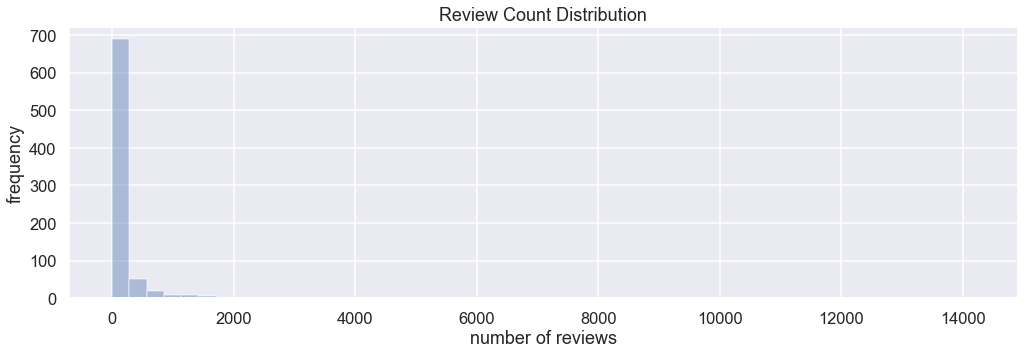

In [20]:
# plotting
ax = sns.distplot(df['count'], kde=False)

# labeling
ax.set_title('Review Count Distribution')
ax.set_ylabel('frequency')
ax.set_xlabel('number of reviews')


**FIGURE 1: Distribution of the number of yelp reviews each park has. The majority of parks have less than 1000 reviews.**

Text(0.5, 0, 'number of reviews')

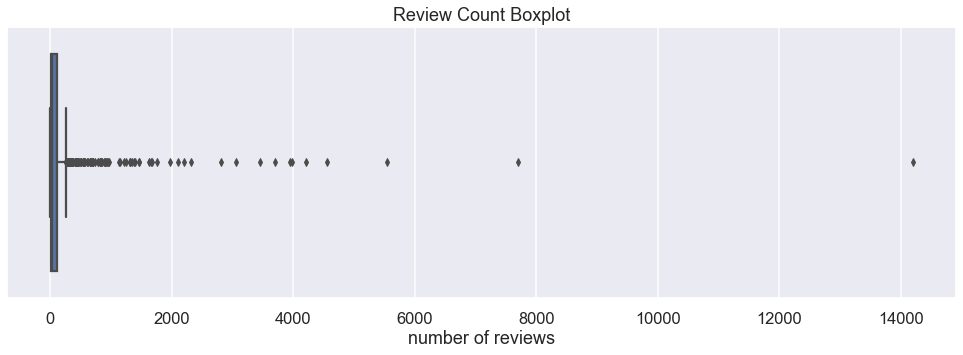

In [21]:
# plotting
ax = sns.boxplot(x=df['count'])

# labeling
ax.set_title('Review Count Boxplot')
ax.set_xlabel('number of reviews')


**FIGURE 2: Boxplot for the number of of yelp reviews of each park. There are many outliers, and notably, one park with over 14000 reviews.**

Despite having many outliers, the more reviews a park has, the more accurate the rating is. As we can see, many parks have close to 0 reviews, which is why it was important to include a Laplace smoothing of the yelp ratings.

Text(0.5, 0, 'number of stars on yelp')

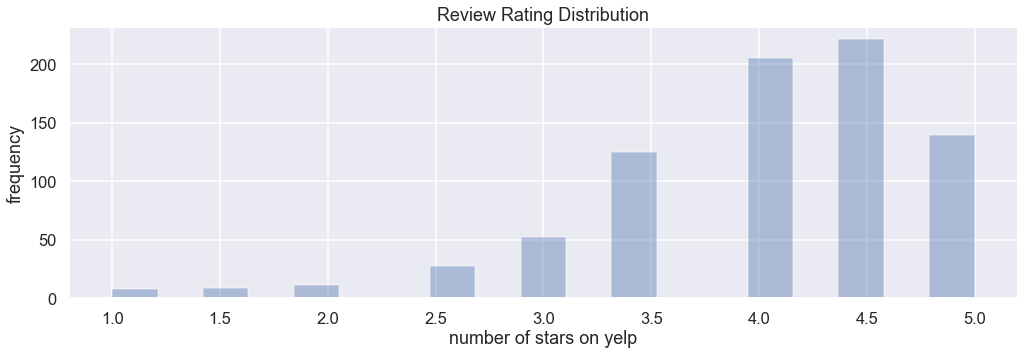

In [22]:
# plotting
ax = sns.distplot(df['rating'], kde=False)

# labeling
ax.set_title('Review Rating Distribution')
ax.set_ylabel('frequency')
ax.set_xlabel('number of stars on yelp')


**FIGURE 3: Distribution of the yelp ratings of the parks. The rating system is from 1 to 5 stars with half stars as well. Most parks got a rating of 3.5 stars or above.**

Text(0.5, 0, 'Laplace smoothing of yelp rating')

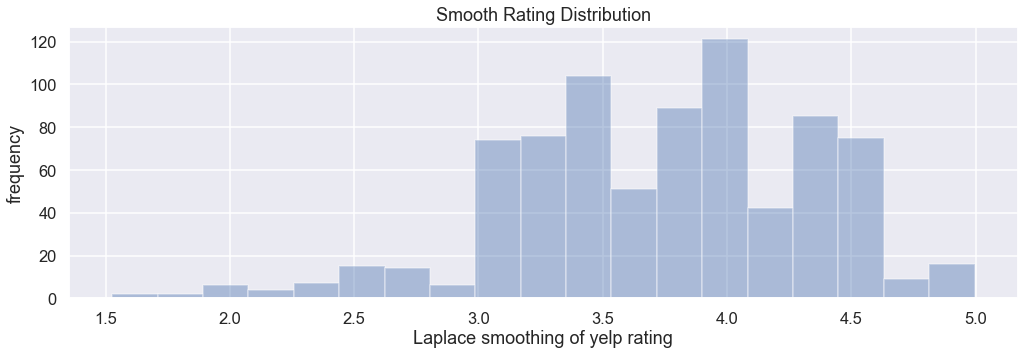

In [23]:
# plotting
ax = sns.distplot(df['smooth'], kde=False)

# labeling
ax.set_title('Smooth Rating Distribution')
ax.set_ylabel('frequency')
ax.set_xlabel('Laplace smoothing of yelp rating')


**FIGURE 4: Distribution of the Laplace smoothed yelp ratings of the parks. The rating system is from 1 to 5 stars still. Parks with a low number of reviews would move closer to 3 stars. Most parks got a smoothed rating of 3 stars or above.**

Text(0.5, 0, 'CES 2.0 Score')

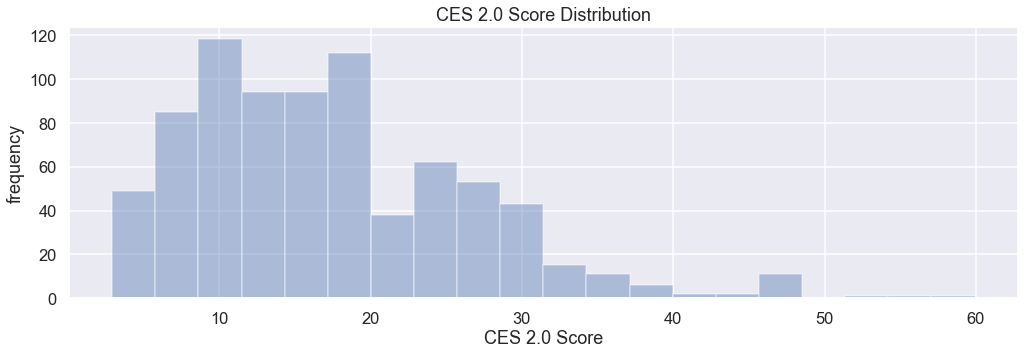

In [24]:
# plotting
ax = sns.distplot(df['score'], kde=False)

# labeling
ax.set_title('CES 2.0 Score Distribution')
ax.set_ylabel('frequency')
ax.set_xlabel('CES 2.0 Score')


**FIGURE 5: Distribution of the CES 2.0 scores of the parks. The scores in San Diego range from 0 up to 60 with a lower score meaning a better/healthier environment. It seems the majority of parks are in a region with a score of less than 20.**

**Note:** These variables do not look normally distributed which may lead to linear regression not being the best approach.

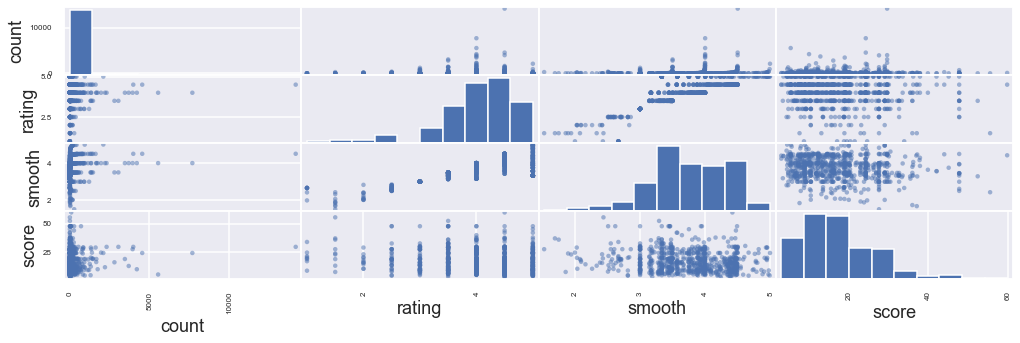

In [25]:
# plotting relationships through scatterplot
fig=pd.plotting.scatter_matrix(df[['count','rating','smooth','score']])


**FIGURE 6: Scatterplot matrix of the amount of reviews, yelp rating, Laplace smoothing rating, and CES 2.0 score**

Here we can see the variables plotted in relation to each other. We want to focus in on how score is related to the original yelp ratings and smoothed ratings.

Text(0.5, 1.0, 'Relationship Between CES score and 5 Star Rating')

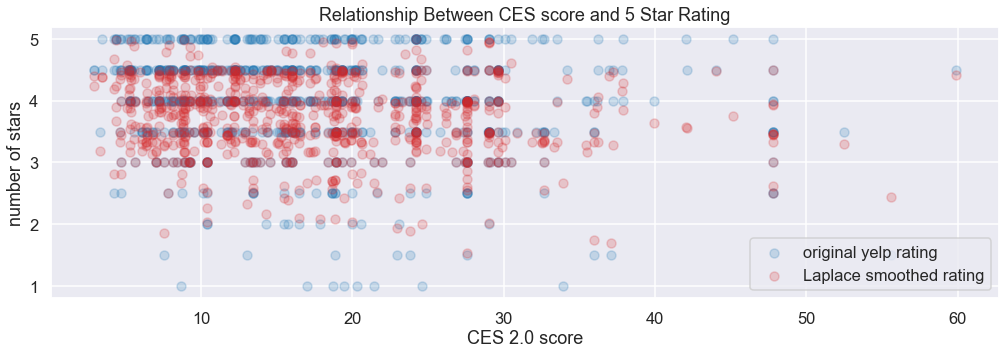

In [26]:
# plotting
plt.scatter(df.score, df.rating, color='tab:blue', alpha=0.2)
plt.scatter(df.score, df.smooth, color='tab:red', alpha=0.2)

# labeling
plt.legend(labels=['original yelp rating', 'Laplace smoothed rating'])
plt.ylabel("number of stars")
plt.xlabel("CES 2.0 score")
plt.title("Relationship Between CES score and 5 Star Rating")


**FIGURE 7: Relationship of CES score and ratings for the parks. It seems that parks with lower CES scores, generally have high ratings.**

Let's do a linear regression analysis to see if it is true that parks with lower CES scores have higher ratings.

In [27]:
# OLS regression and results
o_rating, p_rating = patsy.dmatrices('rating ~ score', df)
m_rating = sm.OLS(o_rating, p_rating)
r_rating = m_rating.fit()
print(r_rating.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.11
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           6.53e-05
Time:                        11:23:33   Log-Likelihood:                -947.24
No. Observations:                 798   AIC:                             1898.
Df Residuals:                     796   BIC:                             1908.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2414      0.060     71.235      0.0

Notice that the "P>|t|" column is 0 for both the intercept and the score which means that they are both significant and we can use them for plotting.

Text(0.5, 1.0, 'Relationship Between CES score and Original Yelp Rating')

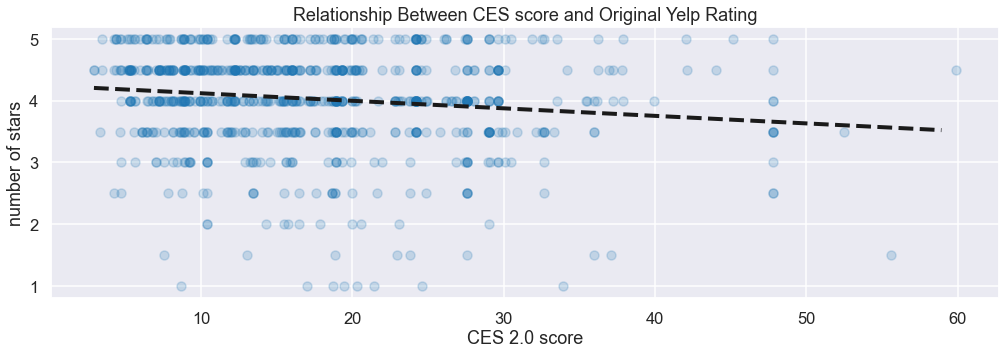

In [28]:
# plotting
xr = np.arange(df.score.min(), df.score.max())
yr = 4.2414 + -0.0122 * xr
fig=plt.plot(xr, yr, '--k', linewidth=4)
fig=plt.scatter(df.score, df.rating, color='tab:blue', alpha=0.2)

# labeling
plt.ylabel("number of stars")
plt.xlabel("CES 2.0 score")
plt.title("Relationship Between CES score and Original Yelp Rating")


**FIGURE 8: Relationship of CES score and original ratings of the parks. The plotted line has a negative slope which means that as the CES score for a park's region rises (the environmental health gets worse), the park's rating slightly decreases.**

In [29]:
# OLS regression and results
o_smooth, p_smooth = patsy.dmatrices('smooth ~ score', df)
m_smooth = sm.OLS(o_smooth, p_smooth)
r_smooth = m_smooth.fit()
print(r_smooth.summary())


                            OLS Regression Results                            
Dep. Variable:                 smooth   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     15.95
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           7.11e-05
Time:                        11:23:33   Log-Likelihood:                -712.69
No. Observations:                 798   AIC:                             1429.
Df Residuals:                     796   BIC:                             1439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8930      0.044     87.724      0.0

Notice that the "P>|t|" column is 0 for both the intercept and the score which means that they are both significant and we can use them for plotting.

Text(0.5, 1.0, 'Relationship Between CES score and Laplace Smoothed Yelp Rating')

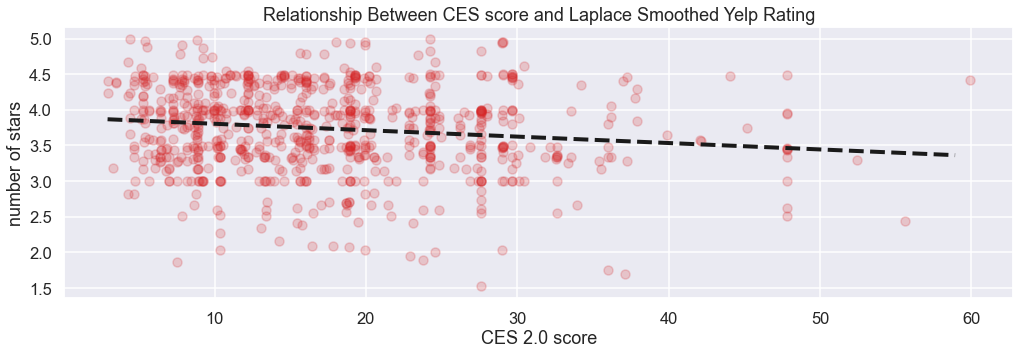

In [30]:
# plotting
xs = np.arange(df.score.min(), df.score.max())
ys = 3.8930 + -0.0090 * xs
fig=plt.plot(xs, ys, '--k', linewidth=4)
fig=plt.scatter(df.score, df.smooth, color='tab:red', alpha=0.2)

# labeling
plt.ylabel("number of stars")
plt.xlabel("CES 2.0 score")
plt.title("Relationship Between CES score and Laplace Smoothed Yelp Rating")


**FIGURE 9: Relationship of CES score and smoothed ratings of the parks. The plotted line has a negative slope which means that as the CES score for a park's region rises (the environmental health gets worse), the park's rating slightly decreases.**

These two results imply that a higher CES score generally means a lower rating on yelp for parks in San Diego!

Let's check if the number of reviews is related to CES score or original yelp ratings too.

In [31]:
o_count, p_count = patsy.dmatrices('count ~ score', df)
m_count = sm.OLS(o_count, p_count)
r_count = m_count.fit()
print(r_count.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.684
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.102
Time:                        11:23:34   Log-Likelihood:                -6417.7
No. Observations:                 798   AIC:                         1.284e+04
Df Residuals:                     796   BIC:                         1.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    120.5104     56.495      2.133      0.0

Using an alpha value of 0.1, the "P>|t|" is greater than our alpha, so this shows that the CES score is not significant in predicting the number of reviews a park will get.

In [32]:
o_count, p_count = patsy.dmatrices('rating ~ count', df)
m_count = sm.OLS(o_count, p_count)
r_count = m_count.fit()
print(r_count.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2052
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.651
Time:                        11:23:34   Log-Likelihood:                -955.14
No. Observations:                 798   AIC:                             1914.
Df Residuals:                     796   BIC:                             1924.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0273      0.029    137.028      0.0

Using an alpha value of 0.1, the "P>|t|" is greater than our alpha, so this shows that the review count is not significant in predicting the rating a park will get.

As mentioned earlier, our variables did not look normally distributed, so below I try my best to normalize the data through transformation, to confirm the linear regression results from above. I mainly did this by testing random powers I could raise the data to for a relative maximum of the probability it came from a normal distribution.

In [33]:
# testing what powers for best normal probability
s=0.34
# graph to visualize if it looks normal but commented out beause it is relatively unimportant
#sns.distplot(np.power(df['score'],s))
st_s, p_s = normaltest(np.power(df.score,s))
p_s


0.0020307211308801033

**Note:** I left out the original yelp ratings as they were not continuous

In [34]:
# testing what powers for best normal probability
r=1.8
# graph to visualize if it looks normal but commented out beause it is relatively unimportant
#sns.distplot(np.power(df['smooth'],r))
st_r, p_r = normaltest(np.power(df.smooth,r))
p_r


0.038838914811483695

In [35]:
# testing what powers for best normal probability
c=0.72
# graph to visualize if it looks normal but commented out beause it is relatively unimportant
#sns.distplot(np.power(np.log(df['count']),c))
st_c, p_c = normaltest(np.power(np.log(df['count']),c))
p_c


0.0004505981128404565

In [36]:
# creating new dataframe with transformed variables
df_normal = pd.DataFrame({'count': np.power(np.log(df['count']),c), 'smooth': np.power(df.smooth,r), 'score': np.power(df.score,s)})

                            OLS Regression Results                            
Dep. Variable:                 smooth   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     15.47
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           9.10e-05
Time:                        11:23:34   Log-Likelihood:                -1999.3
No. Observations:                 798   AIC:                             4003.
Df Residuals:                     796   BIC:                             4012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1582      0.577     22.799      0.0

Text(0.5, 1.0, 'Relationship Between Transformed CES score and Transformed Laplace Smoothed Yelp Rating')

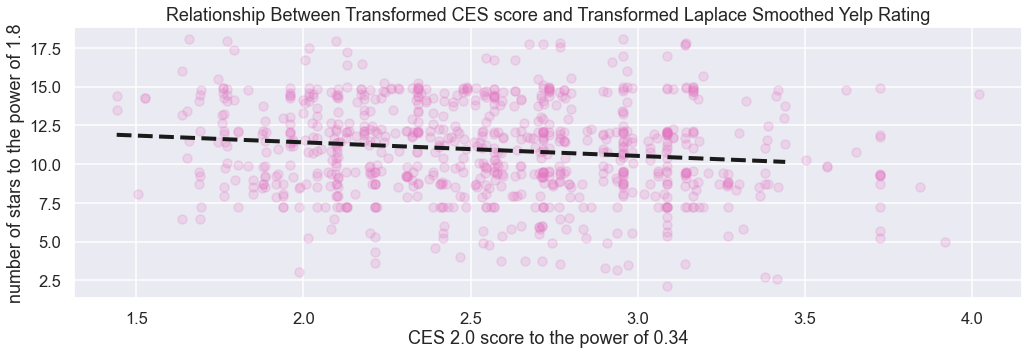

In [37]:
# OLS regression and results
o_normal, p_normal = patsy.dmatrices('smooth ~ score', df_normal)
m_normal = sm.OLS(o_normal, p_normal)
r_normal = m_normal.fit()
print(r_normal.summary())

# plotting
xn = np.arange(df_normal.score.min(), df_normal.score.max())
yn = 13.1582 + -0.8746  * xn
fig=plt.plot(xn, yn, '--k', linewidth=4)
fig=plt.scatter(df_normal.score, df_normal.smooth, color='tab:pink', alpha=0.2)

# labeling
plt.ylabel("number of stars to the power of 1.8")
plt.xlabel("CES 2.0 score to the power of 0.34")
plt.title("Relationship Between Transformed CES score and Transformed Laplace Smoothed Yelp Rating")


**FIGURE 10: Relationship of transformed CES score and transformed smoothed ratings of the parks. The plotted line has a negative slope which means that as the CES score for a park's region rises (the environmental health gets worse), the park's rating slightly decreases (this still applies to the transformed data since both variables were positive values and raising them to a certain power still retains the relationship.**

In [38]:
# OLS regression and results
o_count, p_count = patsy.dmatrices('count ~ score', df_normal)
m_count = sm.OLS(o_count, p_count)
r_count = m_count.fit()
print(r_count.summary())


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2655
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.607
Time:                        11:23:34   Log-Likelihood:                -1210.5
No. Observations:                 798   AIC:                             2425.
Df Residuals:                     796   BIC:                             2434.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1284      0.215      9.909      0.0

Using an alpha value of 0.1, the "P>|t|" is greater than our alpha, so this shows that the transformed CES score is not significant in predicting the transformed number of reviews a park will get.

# Ethics & Privacy

There is no personal information present and the information is available online to the public, so I had no problems with regards to permission to use the data. Luckily, since there was no personally identifiable information present in the datasets I used, there should be no privacy concerns either.

In regards to ethics, a possible bias is that Yelp is only available to those who have access to the internet. Therefore the ratings I am using in the analysis exclude anyone who does not have access to the Internet or Yelp. Regardless, Yelp reviews are biased because many people have opinions on the parks but have not written a review on Yelp, thus Yelp reviews are not truly representative. The goal of my data analysis is to be transparent as possible and call out the possibility that the data could be biased. There could also be the possibility that the results from my analysis are taken as representative throughout all cities, while in reality, it only applies to San Diego. Lastly, there could have been biased data collected that was used to calculate the CalEnviroScreen 2.0 scores, but it seems their data and calculations were done with due diligence. I handled these issues by being transparent throughout my whole process as to not unethically use the data.  This is seen through the notes I make throughout my data cleaning and analysis.

# Conclusion & Discussion

In my project I wanted to find the relationship between yelp review ratings of San Diego parks and the CalEnviroScreen (CES) 2.0 score of the region they are in. I did this by merging the data together so each park from the yelp data that was in San Diego had their respective rating and CES score so they could be easily compared. I also used Laplace smoothing to add smoothed ratings of the yelp reviews to account for skews due to a park having a low number of reviews. Then, I plotted the relationship between both the original ratings and smoothed ratings with the CES scores. Lastly using linear regression, I plotted a best fit line to show the relationship visually. The line showed a negative correlation between the CES score and rating of a park, which is what I predicted in my hypothesis. I believe the reasoning in my hypothesis is still sound, but is important to note that this correlation does not imply causation.

However, in addition to the potential biases I mentioned in the "Ethics and Privacy" section, there were some limitations that could have affected this analysis' results. Mainly, there is probably a better choice than linear regression to analyze the data especially considering my variables did not look normally distributed. I tried my best to remedy this by transforming the data in an attempt to normalize it, but it was probably more convoluted to do this than to choose a better approach. Also, as pointed out earlier, some parks may span across multiple tracts and therefore have multiple CES scores, but I only used the coordinates from the yelp data to find the parks' CES scores. Given more time, I would have liked to try different approaches to analyze the data rather than liner regression, and I would have liked to take the average CES score of all the tracts a park spans across (that is if parks do span across multiple census tracts). It would also be interesting to see what factors from the environment are significantly correlated to the parks' ratings.

Nonetheless, this project can serve as inspiration for others to research the same topic, or it can incentivize parks and local governments to raise their environmental health so citizens have a more enjoyable time at the park. A better environment would better society and park ratings too!